## Modelling for MEDV

### Feature Selection

**Initial Discarded Variables**
- No variables to be discarded with EDA indicating all variables have some sort of correlation with `MEDV`.
- The variable with the lightest relationship with `MEDV` is `CHAS` but it will remain for now.
- `NOX` will not be used as a subsequent model will predict upon it.

**Initial Selected Features**
`CRIM`, `ZN`, `INDUS`, `CHAS`, `RM`, `AGE`, `DIS`, `RAD`, `TAX`, `PTRATIO`, `B`, `LSTAT`

In [146]:
# Install Dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor, callback
from scipy.stats import randint, uniform

In [2]:
df = pd.read_csv(os.path.join("data", "dataset.csv"))
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
target = 'MEDV'

### Pre-processing

In [4]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [5]:
def reflect_then_log(X):
    X_reflect = X.max() + 1 - X
    return np.log1p(X_reflect)

In [48]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['TAXRAD'] = X['TAX'] * X['RAD']
        X.drop(columns=['TAX', 'RAD', 'CHAS', 'AGE', 'ZN'], axis=1)
        return X

In [142]:
# Pre-processing and Model Pipeline

right_skew = ['DIS']
right_skew_outliers = ['CRIM']
left_skew = ['PTRATIO']
left_skew_outliers = ['B']
others = ['INDUS', 'RM', 'TAXRAD', 'LSTAT']

right_skew_transformer = FunctionTransformer(np.log1p, validate=False)
right_skew_outliers_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scale', RobustScaler())
])

# Option for left and right skew = PowerTransformer(method='yeo-johnson')
left_skew_transformer = FunctionTransformer(reflect_then_log, validate=False)
left_skew_outliers_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(reflect_then_log, validate=False)),
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('right_skew', right_skew_transformer, right_skew),
        ('right_skew_outliers', right_skew_outliers_transformer, right_skew_outliers),
        ('left_skew', left_skew_transformer, left_skew),
        ('left_skew_outliers', left_skew_outliers_transformer, left_skew_outliers),
        ('others', StandardScaler(), others)
    ]
)

# Models

lr_model = LinearRegression()

ridge_model = Ridge(
    alpha=1.639,
    solver='sag',
    random_state=37
)

# alpha=1.0,1.639
# solver='auto','sag'

lasso_model = Lasso(
    alpha=0.0079,
    tol=0.00218,
    random_state=37,
    max_iter=9100
)

# alpha=0.1,0.0079
# tol=0.0001,0.00218
# max_iter=1000,9100

rfr_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=3,
    min_samples_split=6,
    min_samples_leaf=3,
    bootstrap=True,
    max_features=0.65,
    random_state=37,
    n_jobs=-1
)

# n_estimators=200,597
# max_depth=6,24
# min_samples_split=5,3
# min_samples_leaf=2,1
# bootstrap=True
# max_features=1,0.45

gbr_model = GradientBoostingRegressor(
    n_estimators=292,
    learning_rate=0.055,
    max_depth=6,
    subsample=0.56,
    min_samples_leaf=3,
    min_samples_split=9,
    random_state=37
)

# n_estimators=150,922,292
# learning_rate=0.1,0.1,0.055
# max_depth=3,8,6
# subsample=0.8,0.54,0.56
# min_samples_leaf=1,4,1
# min_samples_split=2,18,9

xgbr_model = XGBRegressor(
    n_estimators=477,
    learning_rate=0.13,
    max_depth=3,
    subsample=0.95,
    colsample_bytree=0.9,
    gamma=0.36,
    reg_alpha=0.50,
    reg_lambda=1.18,
    random_state=37,
    objective='reg:squarederror'
)

# n_estimators=300,477
# learning_rate=0.05,0.13
# max_depth=4,3
# subsample=0.8,0.95
# colsample_bytree=0.8,0.9
# gamma=0,0.36
# alpha=0,0.50
# lambda=1,1.18

model = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', xgbr_model)
])

### Training

In [ ]:
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predict)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X.shape[1] - 1)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.3f}")
print(f"Adjusted R2: {adjusted_r2:.3f}")

In [135]:
neg_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -neg_mae

print(f"Cross-validated MAE: {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")

Cross-validated MAE: 3.45 ± 0.88


In [75]:
# Tuning

param_dist_ridge = {
    'model__alpha': uniform(0.0001, 1000),
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

param_dist_lasso = {
    'model__alpha': uniform(0.0001, 10),
    'model__max_iter': randint(500, 10000),
    'model__tol': uniform(1e-5, 0.01)
}

param_dist_rf = {
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(3, 30),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': uniform(0.1, 0.9),
    'model__bootstrap': [True, False]
}

param_dist_gb = {
    'model__n_estimators': randint(100, 400),
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_depth': randint(2, 8),
    'model__subsample': uniform(0.5, 0.5),
    'model__min_samples_split': randint(2, 12),
    'model__min_samples_leaf': randint(1, 6)
}

param_dist_xgb = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_depth': randint(2, 10),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__gamma': uniform(0, 0.5),
    'model__reg_alpha': uniform(0, 2),
    'model__reg_lambda': uniform(0.5, 3)
}

rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist_xgb,
    n_iter=1000,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=37,
    verbose=1,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print("\nBest params from Randomized Search:", rs.best_params_)
print(f"Best RMSE from Randomized Search: {-rs.best_score_:.4f}")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits

Best params from Randomized Search: {'model__colsample_bytree': np.float64(0.9029268455866268), 'model__gamma': np.float64(0.36136806601163135), 'model__learning_rate': np.float64(0.1306197949197232), 'model__max_depth': 3, 'model__n_estimators': 477, 'model__reg_alpha': np.float64(0.5009124728718812), 'model__reg_lambda': np.float64(1.17525561099011), 'model__subsample': np.float64(0.953374017975319)}
Best RMSE from Randomized Search: 3.4504


In [10]:
feature_names = right_skew + right_skew_outliers + left_skew + left_skew_outliers + others

coefs = model.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Absolute Coefficient': np.abs(coefs)
}).sort_values(by='Absolute Coefficient', ascending=False)

print(coef_df.head(14))

   Feature  Coefficient  Absolute Coefficient
0      DIS    -5.807210              5.807210
3  PTRATIO     4.926196              4.926196
8    LSTAT    -3.710552              3.710552
1     CRIM    -3.086656              3.086656
6       RM     2.720206              2.720206
5    INDUS    -1.226798              1.226798
7   TAXRAD     1.178000              1.178000
2       ZN     0.901058              0.901058
4        B    -0.105470              0.105470


   Feature  Importance
7    LSTAT    0.459751
5       RM    0.245633
0      DIS    0.085884
2  PTRATIO    0.082860
1     CRIM    0.049237
4    INDUS    0.028784
3        B    0.023937
6   TAXRAD    0.023914


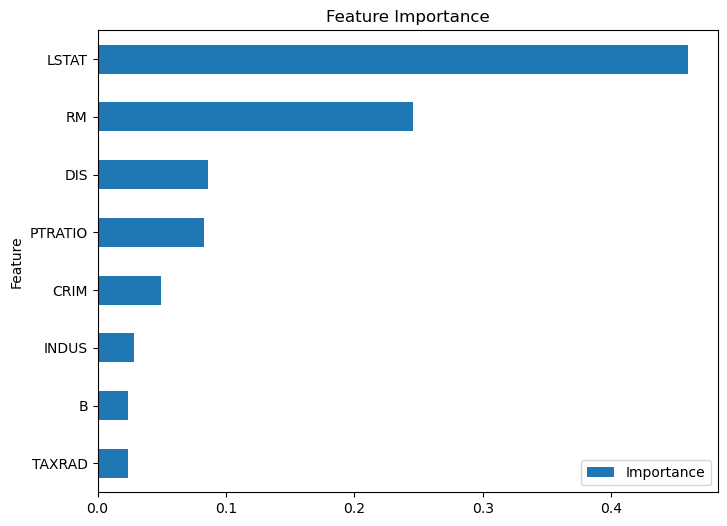

In [79]:
feature_names = right_skew + right_skew_outliers + left_skew + left_skew_outliers + others
importances = model.named_steps['model'].feature_importances_

import_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(import_df.head(10))

import_df.head(15).plot(kind='barh', x='Feature', y='Importance', figsize=(8, 6))
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Visualisations

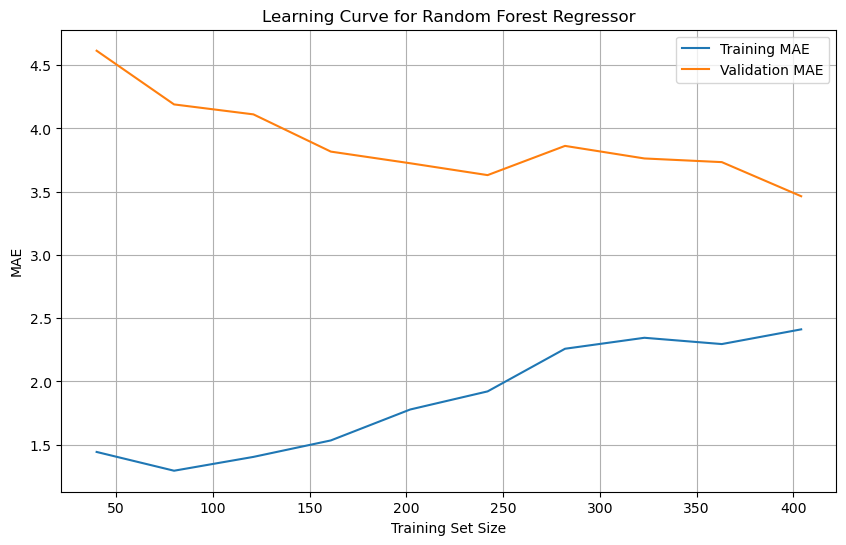

In [138]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MAE')
plt.plot(train_sizes, val_scores_mean, label='Validation MAE')
plt.xlabel('Training Set Size')
plt.ylabel('MAE')
plt.title('Learning Curve for Random Forest Regressor')
plt.legend()
plt.grid(True)
plt.show()

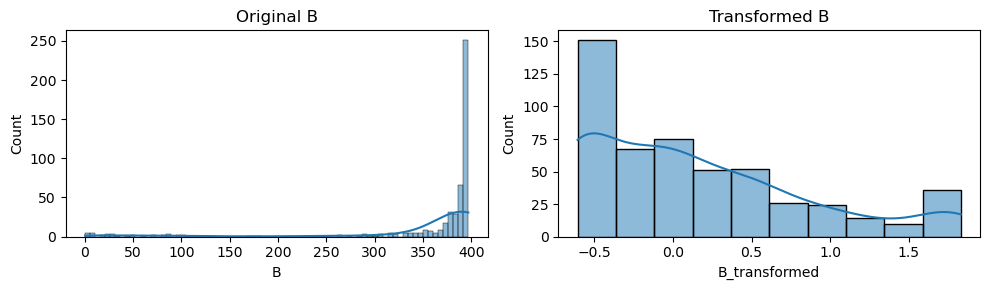

In [181]:
transformed_data = left_skew_outliers_transformer.fit_transform(df[left_skew_outliers])
df_transformed = pd.DataFrame(transformed_data, columns=[f"{col}_transformed" for col in left_skew_outliers])

df_compare = pd.concat([df[left_skew_outliers], df_transformed], axis=1)

plt.figure(figsize=(10, len(left_skew_outliers) * 3))
for i, col in enumerate(left_skew_outliers, 1):
    plt.subplot(len(left_skew_outliers), 2, 2 * i - 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Original {col}")

    plt.subplot(len(left_skew_outliers), 2, 2 * i)
    sns.histplot(df_compare[f"{col}_transformed"], kde=True)
    plt.title(f"Transformed {col}")

plt.tight_layout()
plt.show()